### Implement kernel perceptron algorithm for the classification. The dataset (data55.mat) contains 4 features and the last column is the output (class label). You can use hold-out cross-validation (70, 10, and 20%) for the selection of training, validation and test instances. Evaluate accuracy, sensitivity and specificity measures for the evaluation of test instances. (You can use RBF, and polynomial kernels). (Packages such as keras, tensorflow, pytorch for python and MATLAB deep learning toolbox etc. are not allowed).

In [3]:
#import all the necessory libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from mpl_toolkits import mplot3d

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
root="/content/drive/MyDrive/NNFL_Assignment2/data55.xlsx"
data=pd.read_excel(os.path.join(root),header=None)
data=data.to_numpy()
np.random.shuffle(data)
print(data.shape)

(100, 5)


In [6]:
def onehoten(data):
    y=data[:,-1]
    count=0
    cls=[]
    for insts in range(0,y.shape[0]):
        if y[insts] in cls:
            continue
        else:
            cls.append(y[insts])
    nclasses=len(cls)
    z=np.zeros([y.shape[0],nclasses],dtype=int)
    for insts in range(0,y.shape[0]):
        z[insts,int(y[insts])]=z[insts,int(y[insts])]+1
    return z
        

In [7]:
def split_classes(data):
    x=np.delete(data,-1,1)
    y=onehoten(data)
    c=[]
    for cls in range(0,y.shape[1]):
        temp=[]
        for insts in range(data.shape[0]):
            if y[insts,cls]==1:
                temp.append(data[insts])
        c.append(np.array(temp))
    return(c)

In [8]:
def split_train_test(classes,train_perc,valid_perc):
    train=[]
    test=[]
    valid=[]
    train_insts=int(classes[0].shape[0]*train_perc/100)
    valid_insts=int(classes[0].shape[0]*valid_perc/100)
    test_insts=classes[0].shape[0]-(train_insts+valid_insts)
    for cls in range(0,len(classes)):
        np.random.shuffle(classes[cls])
        traintemp=classes[cls][0:train_insts,:]
        train.append(traintemp)
        testtemp=classes[cls][train_insts:(train_insts+test_insts),:]
        test.append(testtemp)
        validtemp=classes[cls][:valid_insts,:]
        valid.append(validtemp)
    train=np.array(train).reshape(((train_insts*2),5))
    valid=np.array(valid).reshape(((valid_insts*2),5))
    np.random.shuffle(train)
    np.random.shuffle(valid)
    test=np.array(test).reshape((int(classes[0].shape[0]*(100-(train_perc+valid_perc))/100*len(classes)),5))
    np.random.shuffle(test)
    return train,test,valid


In [9]:
def split_x_y(data):
    x=np.delete(data,-1,1)
    x=normalize(x)
    y=data[:,-1].reshape((data.shape[0],1))
    return x,y

In [10]:
def normalize(data):
    for i in range(data.shape[1]):
        temp=data[:,i]
        data[:,i]=(temp-np.mean(temp))/np.std(temp)
    return data

In [11]:
def polker(x, y):
    return (1 + np.dot(x.T, y)) ** 2

In [12]:
def rbfker(x,y):
    return np.exp(-1*(np.linalg.norm(x-y))/0.01)

In [20]:
def pred(c,x_train,y_train,x,type):
    l=0
    for insts in range(x_train.shape[0]):
        if type==1:
            delt=c[insts]*y_train[insts]*polker(x_train[insts],x)
        elif type==2:
            delt=c[insts]*y_train[insts]*rbfker(x_train[insts],x)
        l=l+delt
    h=np.sign(l)
    return h

In [21]:
def train(data,epochs,type):
    classes=split_classes(data)
    train,test,valid=split_train_test(classes,70,10)
    x_train,y_train=split_x_y(train)
    y_train=normalize(y_train)
    x_train=np.concatenate((x_train,np.ones([x_train.shape[0],1])),axis=1)
    x_valid,y_valid=split_x_y(valid)
    y_valid=normalize(y_valid)
    x_valid=np.concatenate((x_valid,np.ones([x_valid.shape[0],1])),axis=1)
    x_test,y_test=split_x_y(test)
    y_test=normalize(y_test)
    x_test=np.concatenate((x_test,np.ones([x_test.shape[0],1])),axis=1)
    c=np.zeros((x_train.shape[0],1))
    h=np.zeros((x_train.shape[0],1))
    hval=np.zeros((x_valid.shape[0],1))
    es=[]
    evals=[]
    for eps in range(epochs):
        e=np.sum(np.square(h-y_train))
        evali=np.sum(np.square(hval-y_valid))
        for k in range(x_valid.shape[0]):
            hval[k]=pred(c,x_train,y_train,x_valid[k],type)
        evals.append(evali)
        for j in range(x_train.shape[0]):
#             print(h[j])
            h[j]=pred(c,x_train,y_train,x_train[j],type)
            # e=e+((h[j]-y_train[j])**2)
#             print(h[j])
            if h[j]!=y_train[j]:
                c[j]=c[j]+1
        es.append(e)
    
    htest=np.zeros((x_test.shape[0],1))
    for k in range(x_test.shape[0]):
            htest[k]=pred(c,x_train,y_train,x_test[k],type)
            etest=np.sum(np.square(htest-y_test))
    print("test error = {}".format(etest))

    return c,es,evals,x_test,y_test,x_train,y_train

In [22]:
c,es,ev,x_test,y_test,x_train,y_train=train(data,30,2)

test error = 0.0


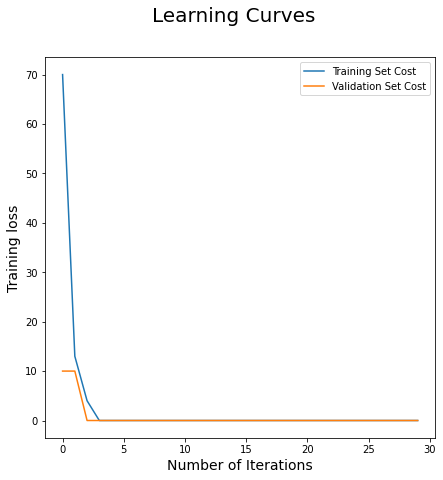

In [ ]:
#For type 1 ie. polynomial kernel
fig=plt.figure()
fig.set_figheight(7)
fig.set_figwidth(7)
fig.suptitle('Learning Curves', fontsize=20)
plt.xlabel('Number of Iterations', fontsize=14)
plt.ylabel('Training loss',fontsize=14)
plt.plot(range(0,len(es)),es, label = 'Training Set Cost')
plt.plot(range(0,len(ev)),ev, label = 'Validation Set Cost')
plt.legend()
plt.show()

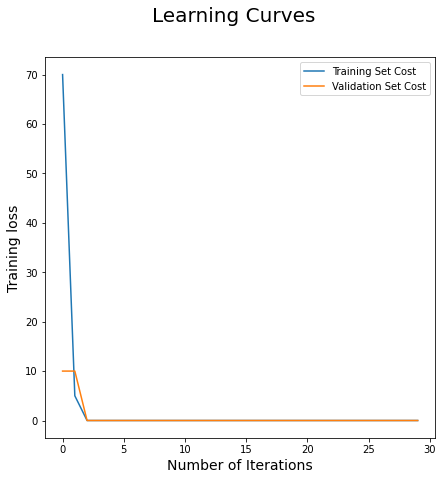

In [23]:
#For type 2 ie. rbfkernel
fig=plt.figure()
fig.set_figheight(7)
fig.set_figwidth(7)
fig.suptitle('Learning Curves', fontsize=20)
plt.xlabel('Number of Iterations', fontsize=14)
plt.ylabel('Training loss',fontsize=14)
plt.plot(range(0,len(es)),es, label = 'Training Set Cost')
plt.plot(range(0,len(ev)),ev, label = 'Validation Set Cost')
plt.legend()
plt.show()

In [26]:
def test (x_train,y_train,x_test,y_test,c,type):
    h_test=np.zeros((x_test.shape[0],1))
    for k in range(x_test.shape[0]):
            h_test[k]=pred(c,x_train,y_train,x_test[k],type)
            etest=np.sum(np.square(h_test-y_test))
    error = (y_test-np.rint(h_test)).tolist()
    sum = (y_test+np.rint(h_test)).tolist()
    FN = error.count([2.0])
    FP = error.count([-2.0])
    TN = sum.count([-2.0])
    TP = sum.count([2.0])
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    sensitivity = TP/(TP+FN)
    specificity = TN/(FP+TN)
    conf_matrix = np.array(([TP,FP],[FN,TN]))
    print(accuracy,sensitivity,specificity)
    print(conf_matrix)

    return accuracy,sensitivity,specificity,conf_matrix

In [ ]:
#For type 1 ie. polynomial kernel
accuracy,sensitivity,specificity,conf_matrix=test(x_train,y_train,x_test,y_test,c,2)

1.0 1.0 1.0
[[10  0]
 [ 0 10]]


In [27]:
#For type 2 ie. rbfkernel
accuracy,sensitivity,specificity,conf_matrix=test(x_train,y_train,x_test,y_test,c,2)

1.0 1.0 1.0
[[10  0]
 [ 0 10]]
